<a href="https://colab.research.google.com/github/ander002/DeepLearning/blob/main/DeepLearning_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 误差反向传播误差
## 计算图
> 计算图是将计算过程用图形表示出来

一个栗子：我在超市买了卖了2个苹果，3个橘子，其中苹果每个100元。橘子每个150元，消费税消费税10%，请计算支付金额。
![计算图](http://pan.anderd.com/download/614864c900bbb4003f248a08)

> 构建了计算图后，从左到右进行计算，就像电路中得的电流一样，计算结构从左向右传递，到达最右边计算结束，算出结果为715。从左向右计算是一种**正向传播**。反之从右到左的传播叫**反向传播**。在训练神经网络时，正向传播和后向传播相互依赖，对于正向传播，我们沿着依赖的方向遍历计算图并计算其路径上所有变量。然后将这些用于反向传播，其中计算顺序与计算图相反。

# 数值稳定和梯度消失、梯度爆炸
1.  梯度爆炸问题：参数更新过大，破坏了模型的稳定收敛
2.  梯度消失问题：参数更新过小，在每一次更新时几乎不会移动，导致无法学习。

In [ ]:
!pip install d2l

     |████████████████████████████████| 83 kB 1.3 MB/s 


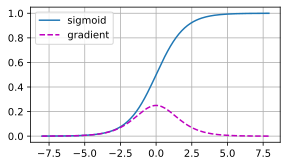

In [ ]:
# 导致梯度消失问题的一个常见原因是跟在每层的线性运算后的激活函数。
%matplotlib inline
import torch
from d2l import torch as d2l

x = torch.arange(-8.0, 8.0, 0.1,requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(),[y.detach().numpy(),x.grad.numpy()],legend=['sigmoid','gradient'],figsize=(4.5,2.5))

> 如上图，当他输入很大或很小的时候，sigmoid函数的梯度都会消失。

In [ ]:
#梯度爆炸

M = torch.normal(0,1,size=(4, 4))
print('一个矩阵\n',M)
for i in range(100):
  M = torch.mm(M,torch.normal(0,1,size=(4,4)))

print('乘以以100个矩阵后\n',M)

一个矩阵
 tensor([[-0.9611,  0.1758,  0.7273,  0.6338],
        [ 1.7195,  0.2438, -0.2530,  0.5058],
        [-1.0773, -1.1959, -1.0119, -1.1041],
        [-0.8114,  3.2348,  0.6318,  0.2106]])
乘以以100个矩阵后
 tensor([[-2.7887e+21,  6.2334e+20,  1.9378e+21, -2.4584e+21],
        [ 3.3448e+21, -7.4764e+20, -2.3242e+21,  2.9486e+21],
        [-4.0709e+20,  9.0993e+19,  2.8288e+20, -3.5886e+20],
        [-4.3436e+20,  9.7089e+19,  3.0183e+20, -3.8290e+20]])


# 层和块
> 下面代码生成一个网络，包涵一个具有一个具有256个单元和relu激活函数的全连接的隐藏层，然后是一个具有10个隐藏单元且不带激活函数的全连接输出层。

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20,256),nn.ReLU(),nn.Linear(256,10)) #Sequential()定义了一个种特殊的Moudel，表示一个块的类。
X = torch.rand(2,20)  #256个单元和relu激活函数的全连接的隐藏层
net(X)

tensor([[ 0.0752, -0.3275, -0.2213, -0.1048,  0.1710, -0.1456,  0.1217, -0.0322,
         -0.1085, -0.1266],
        [ 0.1073, -0.0788, -0.1633, -0.1443,  0.2078, -0.1126,  0.0639, -0.0854,
         -0.0553, -0.0647]], grad_fn=<AddmmBackward>)

## 自定义块
### **块的基本功能**
1. 将输入数据作为其正向传播函数的参数
2. 通过正向传播函数来生成输出
3. 计算其输出关于输入的梯度，可通过其反向传播函数进行访问
4. 存储和访问正向传播计算所需要的参数
5. 根据需要初始化模型参数

In [ ]:
#块的编写，包涵一个多层感知机，有256个隐藏单元的 隐藏层，和一个10维的输出层
class MLP(nn.Module):
  def __init__(self):
    super().__init__()   #初始化一些必要的参数，w，b等
    self.hidden = nn.Linear(20,256) #全连接层
    self.out = nn.Linear(256,10)
  def forward(self,X):
    return self.out(F.relu(self.hidden(X)))  #relu函数在nn的functional里

In [ ]:
net = MLP()
net(X)   #这里实际上的是net.__call__(X) 简写

tensor([[ 0.0432, -0.1057, -0.0829, -0.0429, -0.1537, -0.1763, -0.1291, -0.0175,
          0.0909, -0.0242],
        [-0.0475, -0.0427,  0.0727,  0.0349, -0.1214, -0.1764, -0.0853, -0.0066,
          0.0490,  0.0398]], grad_fn=<AddmmBackward>)

In [ ]:
#顺序快，Sequential的目的是把其他模块串起来。
class MySequential(nn.Module):
  def __init__(self,*args):
    super().__init__()
    for block in args:#这⾥，`block`是`Module`⼦类的⼀个实例。我们把它保存在'Module'类的成员变量
      self._modules[block] = block  #将每一个块逐个添加到有序字典_modules中
  def forward(self,X):
    for block in self._modules.values():#_modules主要优点是，在块的参数初始化过程中，系统知道在_modules字典中查找需要初始化参数的⼦块。
      X = block(X)
    return X

In [ ]:
net = MySequential(nn.Linear(20,256),nn.ReLU(),nn.Linear(256,10))
print(f'{net.forward(X)}\n{net(X)}\n{net.__call__(X)}')#三个等价的计算


tensor([[ 0.0522,  0.0573,  0.1740,  0.1471, -0.2396,  0.0024, -0.2079, -0.1147,
          0.0918,  0.1846],
        [-0.0216,  0.0295,  0.1263,  0.2061,  0.0034, -0.0484, -0.1260, -0.2350,
          0.0744,  0.0927]], grad_fn=<AddmmBackward>)
tensor([[ 0.0522,  0.0573,  0.1740,  0.1471, -0.2396,  0.0024, -0.2079, -0.1147,
          0.0918,  0.1846],
        [-0.0216,  0.0295,  0.1263,  0.2061,  0.0034, -0.0484, -0.1260, -0.2350,
          0.0744,  0.0927]], grad_fn=<AddmmBackward>)
tensor([[ 0.0522,  0.0573,  0.1740,  0.1471, -0.2396,  0.0024, -0.2079, -0.1147,
          0.0918,  0.1846],
        [-0.0216,  0.0295,  0.1263,  0.2061,  0.0034, -0.0484, -0.1260, -0.2350,
          0.0744,  0.0927]], grad_fn=<AddmmBackward>)


In [ ]:
#在正向传播函数中执行代码，更灵活，更方便
class FixedHiddenMLP(nn.Module):
  def __init__(self):
      super().__init__()
      self.rand_weight = torch.rand((20,20),requires_grad=False)
      self.linear = nn.Linear(20,20)
  def forward(self,X):
      X = self.linear(X)
      X = F.relu(torch.mm(X,self.rand_weight)+1)
      X = self.linear(X)
      while X.abs().sum()>1:#如果X的L1范数大于1就将输出向量除以2
        X/=2
      return X.sum()#这段代码可能在实际任务中没有任何用处，只是展示如何将任一代码集成到神经网络计算中

In [ ]:
net = FixedHiddenMLP()
net(X)

tensor(0.2208, grad_fn=<SumBackward0>)

In [ ]:
#我们还可以混搭各种组合块的方法，如下：
class NestMLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(20,64),nn.ReLU(),nn.Linear(64,32),nn.ReLU())
    self.linear = nn.Linear(32,16)
  def forward(self,X):
    return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(),nn.Linear(16,20),FixedHiddenMLP())
chimera(X)

tensor(0.0174, grad_fn=<SumBackward0>)

### 小结
> 1. 层也是块
2. 一个块可以有许多层组成
3. 一个块可以有许多块组成
4. 块可以包含代码
5. 块负责大量的内部处理，包括参数初始化和反向传播
6. 层和块的顺序连接由Sequential块处理。

# 参数管理
>⼀旦我们选择了架构并设置了超参数，我们就进⼊了训练阶段。此时，我们的⽬标是找到使损失函数最小化的参数值。经过训练后，我们将需要使⽤这些参数来做出未来的预测。此外，有时我们希望**提取参数**，以便在其他环境中**复⽤**它们，**将模型保存到磁盘**，以便它可以在其他软件中执⾏，或者为了获得科学的理解而进⾏检查。

In [ ]:
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4,8),nn.ReLU(),nn.Linear(8,1))
X = torch.rand(size=(2,4))
net(X)

tensor([[-0.1284],
        [-0.1401]], grad_fn=<AddmmBackward>)

##访问参数


In [ ]:
# 参数访问
print(net[2].state_dict())# 我们可以通过缩影来访问模型的任意层，结果告诉我们，这个全连接层包涵两个参数，分别是该层的权重和偏置。

OrderedDict([('weight', tensor([[ 0.0406,  0.0912,  0.2881, -0.2390,  0.1471, -0.1757, -0.2387, -0.2774]])), ('bias', tensor([-0.1322]))])


In [ ]:
# 目标参数
print(type(net[2].bias))# 结果表示参数是复合对象，包含值、梯度和额外信息
print(net[2].bias)
print(net[2].bias.data)
print(net[2].weight.grad)#我们还可以访问参数的梯度

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([-0.1322], requires_grad=True)
tensor([-0.1322])
None


In [ ]:
#一次性访问所有参数
print(*[(name,param.shape) for name ,param in net[0].named_parameters()])  #访问第一个全连接层的参数
print(*[(name,param.shape) for name ,param in net.named_parameters()])#访问所有层的参数

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


In [ ]:
net.state_dict()['2.bias'].data#另一种访问网络参数的方式

tensor([-0.1322])

In [ ]:
#从嵌套块收集参数
def block1():
  return nn.Sequential(nn.Linear(4,8),nn.ReLU(),nn.Linear(8,4),nn.ReLU())

def block2():
  net = nn.Sequential()
  for i in range(4):  
    net.add_module(f'block{i}',block1())#在这里嵌套
  return net

rgnet = nn.Sequential(block2(),nn.Linear(4,1))
rgnet(X)

tensor([[-0.1623],
        [-0.1623]], grad_fn=<AddmmBackward>)

In [ ]:
print(rgnet)  #看结果这个嵌套网络层是分层嵌套，我们可以通过嵌套列表索引一样访问它们

Sequential(
  (0): Sequential(
    (block0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


In [ ]:
rgnet[0][3][2].bias.data

tensor([-0.2434,  0.1259, -0.1134,  0.1941])

## 参数初始化
> 深度学习框架提供默认随机初始化，但有些时候，我们希望它根据其他规则初始化权重。所以，深度学习框架提供了最常用的规则，也允许创建自定义初始化方法。**默认情况下**，PyTorch会根据一个范围均匀地初始化权重和偏置矩阵，这个范围是根据输入输出的维度计算出的。当然，PyTorch的nn.init模块也提供了多种预置初始化方法。

In [ ]:
#内置初始化
def init_normal(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight,mean=0,std=0.01)  #将所有权重参数初始化为标准差为0.01的高斯随机变量
    nn.init.zeros_(m.bias)#偏置参数设置为0

net.apply(init_normal)
net[0].weight.data[0],net[0].bias.data[0]

(tensor([ 0.0090, -0.0011,  0.0081,  0.0126]), tensor(0.))

In [ ]:
def init_constant(m):
  if type(m) == nn.Linear:
    nn.init.constant_(m.weight,1) # 将所有参数初始化为给定的常数
    nn.init.zeros_(m.bias)

net.apply(init_constant)
net[0].weight.data[0],net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

In [ ]:
#对不同的块应用不同的初始化方法
def xavier(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)  #这里的xavier初始化是为了使各层的激活值呈现出具有相同广度的分布，具体算法是如果前一层节点数是n，则初始化标准差为1/根号n的分布。

def init_42(m):
  if type(m) == nn.Linear:
    nn.init.constant_(m.weight,42)

net[0].apply(xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([ 0.6738,  0.3571, -0.0437,  0.3182])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


In [ ]:
#自定义初始化；有时深度学习框架没有我们提供需要的初始化方法，我们要自定义初始化了。
def my_init(m):
  if type(m) == nn.Linear:
    print("Init",*[(name,param.shape) for name,param in m.named_parameters()][0])
    nn.init.uniform_(m.weight,-10,10)
    m.weight.data *= m.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[ 9.3861,  8.3629,  0.0000, -6.4611],
        [-0.0000, -5.7580, -5.7729,  6.0639]], grad_fn=<SliceBackward>)

In [ ]:
#注意，我们始终可以直接设置参数
net[0].weight.data[:] += 1
net[0].weight.data[0,0] = 42
net[0].weight.data[0]

tensor([42.0000,  9.3629,  1.0000, -5.4611])

## 参数绑定
> 有时我们希望在多个层之间共享参数，但怎么做呢？在下面我们定义了一个稠密层，然后使用他的参数来设置另一个层的参数。

In [ ]:
shared = nn.Linear(8,8)
net = nn.Sequential(nn.Linear(4,8),nn.ReLU(),shared,nn.ReLU(),shared,nn.ReLU(),nn.Linear(8,1))
net(X)
#检查是否相同
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0,0] = 100
#确保它们实际上是同一个对象，而不只是有相同的值
#net[4].weight.data[0,0]
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


> 这个例子表明第二层和第三层  的参数是绑定的，它们不仅值相等，而且由相同的张量表示。参数绑定，如果改变其中一个参数，另一个参数也会改变。那么问题来了，参数绑定的时候，梯度会发生什么情况？答案是由于模型参数包涵梯度，因此在反向传播期间第二个隐藏层和第三个隐藏层的梯度会加在一起。

# 自定义层
> 深度学习成功背后的⼀个因素是，可以⽤创造性的⽅式组合⼴泛的层，从而设计出适⽤于各种任务的结构。

In [ ]:
#不带参数的层
import torch
import torch.nn.functional as F
from torch import nn

class CenteredLayer(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,X):
    return X - X.mean()   #功能在这里实现，从其输入中减去均值

layer = CenteredLayer()
layer(torch.FloatTensor([1,2,3,4,5]))

tensor([-2., -1.,  0.,  1.,  2.])

In [ ]:
#将层作为组件合并到构建更复杂的模型中

net = nn.Sequential(nn.Linear(8,128),CenteredLayer())

Y = net(torch.rand(4,8))
Y.mean()

tensor(1.4668e-08, grad_fn=<MeanBackward0>)

In [ ]:
#带参数的层
class MyLinear(nn.Module):  #自定义版全连接层，
  def __init__(self,in_units,units):# 该层需要两个参数，一个权重，一个偏置
    super().__init__()
    self.weight = nn.Parameter(torch.randn(in_units,units))
    self.bias = nn.Parameter(torch.randn(units,))
  def forward(self,X):
    linear = torch.matmul(X,self.weight.data)+ self.bias.data
    return F.relu(linear)#用relu作为激活函数

linear = MyLinear(5,3)
linear.weight

Parameter containing:
tensor([[-1.3537,  0.2754,  0.1600],
        [ 1.8350,  0.7790, -0.2381],
        [ 0.4322,  1.8553,  1.3476],
        [-0.8663, -0.2270,  2.2948],
        [ 0.7825, -1.2005,  0.4651]], requires_grad=True)

In [ ]:
linear(torch.rand(2,5))#可以使用自定义层直接执行正向传播计算

tensor([[0.0000, 0.0000, 0.2376],
        [0.0000, 0.0000, 0.0000]])

In [ ]:
#我们可以使用自定义层构建模型。像使用内置的全连接层一样使用自定义层
net = nn.Sequential(MyLinear(64,8),MyLinear(8,1))
net(torch.rand(2,64))

tensor([[14.5781],
        [21.2261]])

### 小结
> 1. 我们可以通过基本层类设计⾃定义层。这允许我们定义灵活的新层，其⾏为与库中的任何现有层不同。
2. 在⾃定义层定义完成后，就可以在任意环境和⽹络结构中调⽤该⾃定义层。
3. 层可以有局部参数，这些参数可以通过内置函数创建。

# 读写文件
> 有时候我们希望保存我们的训练模型来以备将来各种环境中使用，另一种场景，在运行一个耗时比较长的训练过程，我们需要定期保存中间结果，来防止意外情况的突发，完成对数据的保护。

In [ ]:
#保存张量
import torch
from torch import nn
from torch.nn import functional as F

x = torch.arange(4)
torch.save(x,'x-file')

In [ ]:
#加载张量
x2 = torch.load('x-file')
x2

tensor([0, 1, 2, 3])

In [ ]:
#也可以存储一个张量列表，然后把他们读回内存
y = torch.zeros(4)
torch.save([x,y],'x-file')
x2,y2 = torch.load('x-file')
x2,y2

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

In [ ]:
#也可以写入或读取从字符串映射到张量的字典
mydict = {}

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

In [ ]:
#加载和保存模型参数，深度学习框架提供了内置函数来保存和加载整个网络，
#但需要注意的是，这将保存模型的参数而不是保存整个模型。因此为了恢复模型，我们需要用代码生成结构，然后再从磁盘加载参数
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = nn.Linear(20,256)
    self.output = nn.Linear(256,10)
  def forward(self,x):
    return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2,20))
Y = net(X)

In [ ]:
#将模型的参数存储为文件
torch.save(net.state_dict(),'mlp.params')

In [ ]:
#恢复模型，我们去实例化一个MLP
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))#我们没有初始化模型参数，而是直接读取文件中存储的参数
clone.eval()

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
Y_clone = clone(X)
Y_clone == Y  #验证一下，俩个实例具有相同的模型，输入相同的X,两个实例的计算结果应该是一样的。

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

#卷积神经网络
> 1. 平移不变性：不管检测对象出现在图像中德哪个位置，神经网络的前面几层应该对相同的图像区域具有相似的反应。
2. 局部性：神经网络的前面几层应该只探索输入图像中的局部区域，而不过度在意图像中相隔较远区域的关系，这就是局部性原则。最终，在后续神经网络，整个图像级别上可以集成这些局部特征用于预测。





## 互相关运算
![互相关运算](http://pan.anderd.com/download/614fc7deab9f7d003fcc3331)

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def corr2d(X,K):#输入张量X和卷积核Y
  """"计算二维互相关运算"""
  h,w = K.shape
  Y = torch.zeros((X.shape[0]-h+1,X.shape[1]-w+1))#最后结果的形状是可以算出来的
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      Y[i,j] = (X[i:i+h,j:j+w] * K).sum()
  return Y

In [ ]:
#验证二维互相关运算
X = torch.tensor([[0.0,1.0,2.0],[3.0,4.0,5.0],[6.0,7.0,8.0]])
K = torch.tensor([[0.0,1.0],[2.0,3.0]])
corr2d(X,K)

tensor([[19., 25.],
        [37., 43.]])

In [ ]:
#卷积层
class Conv2D(nn.Module):
  def __init__(self,kernel_size):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(kernel_size))
    self.bias = nn.Parameter(torch.zeros(1))
  
  def forward(self,x):
    return corr2d(x,self.weight)+self.bias

In [ ]:
#图像中目标的边缘检测，首先我们来构造一个6x8像素的黑白图像
X = torch.ones((6,8))
X[:,2:6] = 0
X   #其中，中间四列为黑色，其余为白色，黑白边缘分明。

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [ ]:
K = torch.tensor([[1.0,-1.0]])#构造一个高度为1、宽度为2的卷积核K,这样在进行运算的时候，如果水平相邻的元素相同则输出为0，否则输出为非0

Y = corr2d(X,K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [ ]:
#但是有一个问题，高度为1宽度为2的卷积核只能检测垂直边缘，无法检测水平边缘，如下
corr2d(X.t(),K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [ ]:
#为了解决上述问题，可通过学习卷积核，让机器自己生成卷积核。
#构造一个二维卷积层，具有一个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1,1,kernel_size=(1,2),bias=False)

#这个二维卷积层，使用思维输入和输出格式（批量大小，通道，高度，宽度)，其中批量大小和通道都为1
X = X.reshape((1,1,6,8))
Y = Y.reshape((1,1,6,7))

for i in range(10):
  Y_hat = conv2d(X)
  l = (Y_hat - Y) ** 2
  conv2d.zero_grad()
  l.sum().backward()
  #迭代卷积核
  conv2d.weight.data[:] -= 3e-2 * conv2d.weight.grad#相当于前面的  w = w-lr*grad，更新权重
  if (i+1) % 2 == 0:
    print(f'batch {i+1},loss {l.sum():.3f}')

batch 2,loss 5.185
batch 4,loss 0.870
batch 6,loss 0.146
batch 8,loss 0.025
batch 10,loss 0.004


In [ ]:
#在10次迭代之后，误差已经降到足够低了。已经接近我们的准确值了
conv2d.weight.data.reshape((1,2))

tensor([[ 0.9877, -0.9886]])

## 填充和步幅
### 填充（padding）
> 在进行卷积层处理之前，有时要向数据的周围填入固定的数据（比如0等），这叫**填充**，在卷积层想要保持运算结果空间大小不变的情况，可以用填充。

### 步幅（Stride）
> 应用滤波器（卷积核）的位置之间的间隔称为**步幅**

###与输出的关系
> 卷积的输出形状取决与输入形状和卷积核的形状。具体关系如下：增大步幅后，输出大小会变小，而增大填充后输出大小会变大。用式子表达是OH=$\frac{H+2P-FH}{S}+1$,              OW=$\frac{W+2P-FW}{S}+1$  (其中，输入大小为（H，W），滤波器（卷积核）大小（FH，FW），输出大小为（OH，OW），填充为P，步幅为S），注意：**OH和OW都向下取整**。
### 小规律
> * 卷积神经⽹络中卷积核的⾼度和宽度通常为奇数，例如 1、3、5 或 7。选择奇数的好处是，保持空间维度的同时，我们可以在顶部和底部填充相同数量的⾏，在左侧和右侧填充相同数量的列。
* 当垂直步幅为$s_h$、⽔平步幅为$s_w$时，输出形状为$⌊rac{(n_h − k_h + p_h + s_h)}{s_h}⌋ × ⌊rac{(n_w − k_w + p_w + s_w)}{s_w}⌋$


In [ ]:
import torch
from torch import nn

# 为了⽅便起⻅，我们定义了⼀个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输⼊和输出提⾼和缩减相应的维数

def comp_conv2d(conv2d, X):
# 这⾥的（1，1）表⽰批量⼤⼩和通道数都是1
  X = X.reshape((1, 1) + X.shape)#rehsape成4维的张量
  Y = conv2d(X)
# 省略前两个维度：批量⼤⼩和通道
  return Y.reshape(Y.shape[2:])
# 请注意，这⾥每边都填充了1⾏或1列，因此总共添加了2⾏或2列
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape#当卷积核的⾼度和宽度不同时，我们可以填充不同的⾼度和宽度，使输出和输⼊具有相同的⾼度和宽度。

torch.Size([8, 8])

In [ ]:
#我们将⾼度和宽度的步幅设置为2，从而将输⼊的⾼度和宽度减半。
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [ ]:
#如果行和列填充不一样，步幅也不一样，虽然通常我们不会这么做
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

##小结
> 1. 填充可以增加输出的⾼度和宽度。这常⽤来使输出与输⼊具有相同的⾼和宽。
2. 步幅可以减小输出的⾼和宽，例如输出的⾼和宽仅为输⼊的⾼和宽的 1/n（n 是⼀个⼤于 1 的整数）。
3. 填充和步幅可⽤于有效地调整数据的维度。


## 多输入多输出通道
###多输入通道
>当输入包含多个通道时，需要构造一个与输入数据具有相同输入通道数目的卷积核，这样我们可以得到形状为$c_i\times k_h\times k_w$的卷积核。由于输入和卷积核都有$c_i$个通道，我们可以对每个通道输入的二维张量和卷积核的二维张量进行互相关运算，在对通道求和（将$c_i$的结果相加）得到二维张量。

![两个输入通道的互相关计算](http://pan.anderd.com/download/615055bb43b188003fe3db23)

In [ ]:
import torch
from d2l import torch as d2l

def corr2d_multi_in(X,K):
  return sum(d2l.corr2d(x,k) for x,k in zip(X,K))#先遍历X和K的第0个维度（通道维度），再把他们加起来

X = torch.tensor([[[0.0,1.0,2.0],[3.0,4.0,5.0],[6.0,7.0,8.0]],
                  [[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,9.0]]])

K = torch.tensor([[[0.0,1.0],[2.0,3.0]],[[1.0,2.0],[3.0,4.0]]])

corr2d_multi_in(X,K)

tensor([[ 56.,  72.],
        [104., 120.]])

###多输出通道
>在最流行的神经网络架构中，随着神经网络层数的加深，我们常常会增加输出通道的维数，通过减少空间分辨率以获得更大的通道深度，直观的说，我们可以将每个输出通道看做是**对不同特征的响应**。为了获得多个通道的输出，我们可以为每个输出通道创建一个形状为$c_i \times k_h \times k_w$的卷积核张量，这样卷积核的形状是$c_o \times c_i \times k_h \times k_w$。

In [ ]:
def corr2d_multi_in_out(X,K):
  return torch.stack([corr2d_multi_in(X,k) for k in K],0)#迭代K的第0个维度，每次都对输入X执行互相关运算

In [ ]:
K1 = torch.tensor([[[0.0,1.0],[2.0,3.0]],[[1.0,2.0],[3.0,4.0]]])
K1 = torch.stack((K1,K1+1,K1+2),0)#通过将核张量K与K+1和K+2连接起来，构造了一个具有3个输出通道的卷积核。
K1.shape

torch.Size([3, 2, 2, 2])

In [ ]:
corr2d_multi_in_out(X,K1)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [ ]:
#torch.stack()函数
#stack（tensors,dim=0,out=None）函数的运行机制可以等价为：
#
#dim=0时，将tensor在一维上连接，简单来说就是，就是将tensor1，tensor2…tensor n,连接为【tensor1，tensor2… tensor n】（就是在这里产生了扩维）
#dim=1时，将每个tensor的第i行按行连接组成一个新的2维tensor，再将这些新tensor按照dim=0的方式连接。
#dim=2时，将每个tensor的第i行转置后按列连接组成一个新的2维tensor，再将这些新tesnor按照dim=0的方式连接
#

a = torch.tensor([[1,2,3],[4,5,6]])
b = torch.tensor([[10,20,30],[40,50,60]])
c = torch.tensor([[100,200,300],[400,500,600]])

print(torch.stack([a,b,c],dim=0))
print(torch.stack([a,b,c],dim=1))
print(torch.stack([a,b,c],dim=2))
print(torch.stack([a,b,c],dim=0).size())
print(torch.stack([a,b,c],dim=1).size())
print(torch.stack([a,b,c],dim=2).size())

tensor([[[  1,   2,   3],
         [  4,   5,   6]],

        [[ 10,  20,  30],
         [ 40,  50,  60]],

        [[100, 200, 300],
         [400, 500, 600]]])
tensor([[[  1,   2,   3],
         [ 10,  20,  30],
         [100, 200, 300]],

        [[  4,   5,   6],
         [ 40,  50,  60],
         [400, 500, 600]]])
tensor([[[  1,  10, 100],
         [  2,  20, 200],
         [  3,  30, 300]],

        [[  4,  40, 400],
         [  5,  50, 500],
         [  6,  60, 600]]])
torch.Size([3, 2, 3])
torch.Size([2, 3, 3])
torch.Size([2, 3, 3])


## $1 \times 1$ 卷积层
>&emsp;&emsp;卷积的本质是有效提取相邻像素间的相关特征，而 1 × 1 卷积显然没有此作⽤。其实 1 × 1 卷积的唯⼀计算发⽣在通道上。1 × 1 卷积层通常⽤于调整⽹络层的通道数量和控制模型复杂性。


&emsp;&emsp;这⾥输⼊和输出具有相同的⾼度和宽度，输出中的每个元素都是从输⼊图像中同⼀位置的元素的线性组合。我们可以将 1 × 1 卷积层看作是在每个像素位置应⽤的全连接层，以$c_i$ 个输⼊值转换为$c_o$ 个输出值。

![](http://pan.anderd.com/download/61506559cd4aad003f800488)

In [ ]:
def corr2d_multi_in_out_1x1(X, K):
  c_i, h, w = X.shape
  c_o = K.shape[0]
  X = X.reshape((c_i, h * w))
  K = K.reshape((c_o, c_i))
  Y = torch.matmul(K,X)
  return Y.reshape(c_o,h,w)

In [ ]:
X = torch.normal(0, 1, (3, 3, 3))#torch.normal (means, std, out =None) 返回一个张量，包含从给定参数 means, std 的离散正态分布中抽取随机数。
K = torch.normal(0, 1, (2, 3, 1, 1))

In [ ]:
Y1 = corr2d_multi_in_out_1x1(X, K)#当执行当执行1x1卷积运算时，相当于先前实现的互相关函数corr2d_multi_in_out
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6
Y1==Y2

tensor([[[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]]])

## 池化层（汇聚层）
> &emsp;&emsp;通常当我们处理图像时，我们希望逐渐降低隐藏表⽰的空间分辨率，聚集信息，这样随着我们在神经⽹络中层叠的上升，每个神经元对其敏感的感受野（输⼊）就越⼤。池化（pooling）层，它具有**双重⽬的**：降低卷积层对位置的敏感性，同时降低对空间降采样表⽰的敏感性。

### 最大池化层和平均池化层
> &emsp;&emsp;在这两种情况下，与互相关运算符⼀样，池化窗口从输⼊张量的左上⻆开始，从左到右、从上到下的在输⼊张量内滑动。在池化窗口到达的每个位置，它计算该窗口中输⼊⼦张量的最⼤值或平均值，具体取决于是使⽤了最⼤汇聚层还是平均汇聚层。下图为最大池化层：

![最大池化层](http://pan.anderd.com/download/6151a857a8f327003f89a1e1)


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
#池化层
def pool2d(X,pool_size,mode='max'):
  p_h, p_w = pool_size
  Y = torch.zeros((X.shape[0] - p_h +1,X.shape[1] - p_w + 1))
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      if mode == 'max':
        Y[i,j] = X[i: i + p_h, j: j + p_w].max()
      elif mode == 'avg':
        Y[i,j] = X[i: i + p_h, j: j + p_w].mean()
  return Y

In [ ]:
X = torch.tensor([[0.0,1.0,2.0],[3.0,4.0,5.0],[6.0,7.0,8.0]])#最大池化层
pool2d(X,(2,2))

tensor([[4., 5.],
        [7., 8.]])

In [ ]:
#平均池化层
pool2d(X,(2,2),'avg')

tensor([[2., 3.],
        [5., 6.]])

In [ ]:
#与卷积层一样，汇聚层也可以改变输出形状，也是通过填充和步幅。
X = torch.arange(16,dtype=d2l.float32).reshape((1,1,4,4))
X  #构造一个输入张量

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [ ]:
#一般情况下，深度学习框架中的步幅与池化窗口的大小相同，因此，如果我们使用形状为（3，3）的池化窗口，得到的步幅形状为（3，3）
pool2d = nn.MaxPool2d(3)
pool2d(X)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[[[10.]]]])

In [ ]:
#步幅和填充可以手工设定
pool2d = nn.MaxPool2d(3,padding=1,stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [ ]:
#也可以随意设定池化窗口的形状，填充和步幅的高度和宽度。
pool2d = nn.MaxPool2d((2,3),padding=(1,1),stride=(2,3))
pool2d(X)

tensor([[[[ 1.,  3.],
          [ 9., 11.],
          [13., 15.]]]])

## 多个通道
> &emsp;&emsp;在处理多通道输入数据时，汇聚层在每个输⼊通道上单独运算，而不是像卷积层⼀样在通道上对输⼊进⾏汇总。这意味着汇聚层的输出通道数与输⼊通道数相同。

In [ ]:
#通过cat构建具有两个通道的输入
X = torch.cat((X,X+1),1)#cat（）和satck（）的区别是cat是续接，维度不变，stack是堆叠，增加一个维度。
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [ ]:
#池化
pool2d = nn.MaxPool2d(3,padding=1,stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

###小结


*   对于给定输⼊元素，最⼤汇聚层会输出该窗口内的最⼤值，平均汇聚层会输出该窗口内的平均值。
* 汇聚层的主要优点之⼀是减轻卷积层对位置的过度敏感。
* 我们可以指定汇聚层的填充和步幅。
* 使⽤最⼤汇聚层以及⼤于 1 的步幅，可减少空间维度（如⾼度和宽度）。
* 汇聚层的输出通道数与输⼊通道数相同。






#LeNet

> 最早发布的卷积神经网络之一，广泛应用于计算机视觉任务中。LeNet（LeNet-5）由两个部分组成：* 卷积编码器：由两个卷积层组成; * 全连接层密集块：由三个全连接层组成。

![LeNet](http://pan.anderd.com/download/6151b80d81e677003fa24ae8)

> 一些名词：上采样、下采样
* 缩小图像（或称为下采样（subsampled）或降采样（downsampled））
主要目的有两个：
1、使得图像符合显示区域的大小；
2、生成对应图像的缩略图。
* 放大图像（或称为上采样（upsampling）或图像插值（interpolating））
主要目的是：
放大原图像,从而可以显示在更高分辨率的显示设备上。对图像的缩放操作并不能带来更多关于该图像的信息, 因此图像的质量将不可避免地受到影响。然而，确实有一些缩放方法能够增加图像的信息，从而使得缩放后的图像质量超过原图质量的。

In [ ]:
#LeNet
import torch
from torch import nn
from d2l import torch as d2l

class Reshape(torch.nn.Module):
  def forward(self,x):
    return x.view(-1,1,28,28)#和reshape无太大区别，view对数据不会发生变化，数据不会挪位置，两者选择没多大区别

net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1,6,kernel_size=5, padding=2),nn.Sigmoid(),  #卷积层输入为1通道，输出6通道，卷积核5x5，填充两行（每一边填充两行）
    nn.AvgPool2d(kernel_size=2,stride=2),#平均池化层，步幅和卷积核都是2可以保证窗口不重叠
    nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),#Conv2d函数默认padding为0，默认stride为1。高宽减半，通道数变两倍
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10)
)

In [ ]:
X = torch.rand(size=(1,1,28,28),dtype=torch.float32)# 检查模型
for layer in net:#查看每一层输出的形状，完全可以手动推算出来，每个汇聚层都将高度和宽度减半
  X = layer(X)
  print(layer.__class__.__name__,'output shape: \t',X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [ ]:
#模型训练，还是用Fishon-Mnist数据集
batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    """使用GPU计算模型在数据集上的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # BERT微调所需的（之后将介绍）
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)。"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，范例数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.484, train acc 0.819, test acc 0.800
25907.9 examples/sec on cuda:0


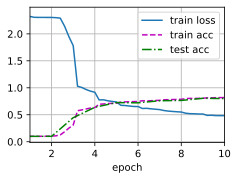

In [ ]:
lr,num_epochs = 0.9,10
train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())#激活函数可以改为relu函数，学习率调低，增加epoch ，test acc会达到0.87

### 小结
> * 卷积神经⽹络（CNN）是⼀类使⽤卷积层的⽹络。
* 在卷积神经⽹络中，我们组合使⽤卷积层、⾮线性激活函数和汇聚层。
* 为了构造⾼性能的卷积神经⽹络，我们通常对卷积层进⾏排列，逐渐降低其表⽰的空间分辨率，同时增加通道数。
* 在传统的卷积神经⽹络中，卷积块编码得到的表征在输出之前需由⼀个或多个全连接层进⾏处理。
* LeNet是最早发布的卷积神经⽹络之⼀。